After IDL tracking, this notebook collects track files, does preprocessing (removing outliers, filling in missing values, cropping times)

1. Run this block to set up 



In [68]:
from ht2.utils import *
from ht2.quant import *
from ht2.qc import *
from ht2.io_handler import *
import shutil as sh
import pandas as pd

g_template = "{cell}G_{reg}ot{spot}_t{len}.{extension}"
r_template = "{cell}R_{reg}ot{spot}_t{len}.{extension}"


# TODO Keep images and tracks together, refit spots using track and image data, compute noise priors, 


def batch_read_tracks(f_list, 
    trk_template
    ):
    test_tracks = []
    for fpath in f_list:
        fpath = Path(fpath)
        parsed_keys = parse.parse(trk_template, fpath.name)
        temp = pd.read_csv(fpath, sep="\s+", header=None)
        #print(temp)
        temp.columns = ["x", "y", "I", "t", "state"]
        temp["cell"] = int(parsed_keys["cell"]) # type: ignore
        if "spot" in parsed_keys.named.keys():
            temp["ID"] = int(parsed_keys["spot"]) # type: ignore
        else:
            temp["ID"] = 3
        temp["UUID"] = temp["cell"].astype(str) + "_" + temp["ID"].astype(str)
        test_tracks.append(temp)
    full_df = pd.concat(test_tracks)
    full_df["ID"] = full_df["ID"].astype(int)
    return full_df

def fwf_writer(fname, df):
    # TODO figure out how to automatically create format spec
    with open(fname, "w") as f:
        if isinstance(df, pd.DataFrame):
            for i, data in df.iterrows():
                f.write("".join(["{:>11.3f}    ".format(num) for num in data])+"\n")
        else:
            for data in df:
                f.write("".join(["{:>11.3f}    ".format(num) for num in data])+"\n")


def new_qc(g_df, gpath, ch, normalize=True):
    g_df_qc = []
    for i, (UUID, group) in enumerate(g_df.groupby("UUID")):
        trk_df = group.drop_duplicates(subset="t", keep="first")
        outliers = trk_df["I"] > (4096 * 3)
        trk_df.loc[outliers, "I"] = pd.NA
        time_range = pd.RangeIndex(start=trk_df['t'].min(), stop=trk_df['t'].max() + 1)
        df_continuous = trk_df.set_index('t').reindex(time_range).reset_index()
        df_continuous.rename(columns={'index': 't'}, inplace=True)
        df_continuous['I'] = df_continuous['I'].fillna(np.nanpercentile(df_continuous["I"], 10))
        df_continuous['x'] = df_continuous['x'].interpolate(method='linear')
        df_continuous['y'] = df_continuous['y'].interpolate(method='linear')
        trk_df = df_continuous.copy()
        if len(trk_df["t"]) != trk_df["t"].max() - trk_df["t"].min()+1:
            print(UUID)
        trk_df["UUID"] = UUID
        trk_df.loc[:,"state"] = 0
        trk_df.drop(index=0, inplace=True)
        if normalize:
            trk_df['I'] = robust_z_score(trk_df["I"])

        g_df_qc.append(trk_df)
    g_df_qc = pd.concat(g_df_qc)
    if normalize:
        g_df_qc["I"] = ((1000 * (g_df_qc["I"] - np.nanmin(g_df_qc["I"])))).astype(int)
    for i, (UUID, trk_df) in enumerate(g_df.groupby("UUID")):
        fwf_writer(gpath.joinpath("{:03d}{}_DualColor_segChG.trk".format(i, ch)), trk_df[["x", "y", "I", "t", "state"]])
    return g_df_qc

def write_matched(g_df_qc, r_df_qc, cpath, spath, dist_threshold=5, min_lifetime=20, n=500, ): 
    """
    g_df_qc: preprocessed dataframe containing all green tracks
    r_df_qc: preprocessed dataframe containing all  red  tracks
    cpath: Coupled tracks output
    spath: shuffled tracks output
    dist_threshold: distance threshold for collision
    min_lifetime: minimum collision time to be considered coupled
    n = number of permutations
    """
    matched = naive_match_collisions(g_df_qc, r_df_qc, threshold=dist_threshold, min_lifetime=min_lifetime)
    print(matched, "\n",len(matched))
    print("matching")
    for i, (gid, rid) in enumerate(matched):
        gtrk = g_df_qc[g_df_qc["UUID"] == gid]
        rtrk = r_df_qc[r_df_qc["UUID"] == rid]
        min_t = max(gtrk["t"].min(), rtrk["t"].min())
        max_t = min(gtrk["t"].max(), rtrk["t"].max())
        gtrk = gtrk[(gtrk["t"] < max_t) * (gtrk["t"] > min_t)]
        rtrk = rtrk[(rtrk["t"] < max_t) * (rtrk["t"] > min_t)]
        fwf_writer(cpath.joinpath("{:03d}G_DualColor_segChG.trk".format(i)), gtrk[["x", "y", "I", "t", "state"]])    
        fwf_writer(cpath.joinpath("{:03d}R_DualColor_segChG.trk".format(i)), rtrk[["x", "y", "I", "t", "state"]])

    idx = np.mod(np.arange(n), len(matched))
    r_idx = np.random.permutation(n)
    r_idx = np.mod(r_idx, len(matched))
    print("shuffling")
    for j, i in enumerate(r_idx):
        gid = matched[idx[j]][0]
        rid = matched[i][1]
        gtrk = g_df_qc[g_df_qc["UUID"] == gid][["x", "y", "I", "t", "state"]].copy()
        rtrk = r_df_qc[r_df_qc["UUID"] == rid][["x", "y", "I", "t", "state"]].copy()
        min_t = max(gtrk["t"].min(), rtrk["t"].min())
        max_t = min(gtrk["t"].max(), rtrk["t"].max())

        gtrk = gtrk[(gtrk["t"] < max_t) * (gtrk["t"] > min_t)]
        rtrk = rtrk[(rtrk["t"] < max_t) * (rtrk["t"] > min_t)]
        gtrk["t"] = gtrk["t"] - gtrk["t"].min()
        rtrk["t"] = rtrk["t"] - rtrk["t"].min()
        fwf_writer(spath.joinpath("{:03d}G_DualColor_segChG.trk".format(j)), gtrk[["x", "y", "I", "t", "state"]])    
        fwf_writer(spath.joinpath("{:03d}R_DualColor_segChG.trk".format(j)), rtrk[["x", "y", "I", "t", "state"]]) 

def preprocess_tracks(path_list, out_path, out_path2=None, normalize=[True, True], save_images=True):
    out_path = Path(out_path)
    check_dir(out_path, create_if_not=True)
    gpath = out_path.joinpath("gene")
    rpath = out_path.joinpath("enhancer")
    cpath = out_path.joinpath("coupled")
    spath = out_path.joinpath("shuffled")
    for i in [gpath, rpath, cpath, spath]:
        check_dir(i, create_if_not=True)
        sh.copy2(r"fcsApp.sav", i)

    trk_list = []
    indices = []
    for i, search_path in enumerate(path_list):
        temp_list = list(Path(search_path).joinpath("sc_idl").glob("*\\*.trk"))
        trk_list.extend(temp_list)
        indices.extend([i+1 for j in range(len(temp_list))])
    if len(trk_list) == 0:
        raise RuntimeError("No tracks found")
    for i, trk_path in enumerate(trk_list):
        # print(trk_path)
        i = indices[i]
        new_name = trk_path.name
        new_name = str(i) + new_name
        sh.copy2(trk_path.parent.joinpath(trk_path.name.replace(".trk", ".tif")), out_path.joinpath(new_name.replace(".trk", ".tif")))
        sh.copy2(trk_path, out_path.joinpath(new_name))

    g_list = list(out_path.glob("*G_*ot*_t*.trk"))
    r_list = list(out_path.glob("*R_*ot*_t*.trk"))
    if len(g_list) == 0 and len(r_list) == 0:
        raise RuntimeError("Naming convention does not match")

    print("reading")
    g_df = batch_read_tracks(g_list, g_template)
    r_df = batch_read_tracks(r_list, r_template)
    print("qc")
    g_df_qc = new_qc(g_df, gpath, "G", normalize=True)
    r_df_qc = new_qc(r_df, rpath, "R", normalize=True)
    if save_images:
        for i, g_trk_path in enumerate(g_list):
            im_path = g_trk_path.parent.joinpath(g_trk_path.name.replace(".trk", ".tif"))
            sh.copy2(im_path, gpath.joinpath("{:03d}G_image.tif".format(i)))
        for i, r_trk_path in enumerate(r_list):
            im_path = r_trk_path.parent.joinpath(r_trk_path.name.replace(".trk", ".tif"))
            sh.copy2(im_path, rpath.joinpath("{:03d}R_image.tif".format(i)))
    print("Found matched pairs:")
    write_matched(g_df_qc, r_df_qc, cpath, spath)
    plt.hist(g_df_qc["I"], 1000)
    plt.show()
    plt.hist(r_df_qc["I"], 1000)
    plt.show()
    
    if out_path2 is not None:
        out_path2 = Path(out_path2)
        check_dir(out_path2, create_if_not=True)
        print("copying to local...")
        sh.copytree(out_path, out_path2)
    return g_df_qc, r_df_qc

def SG_qc(g_df, gpath, ch, normalize=True):
    ch_map = {"G":"gene", "R":"enhancer"}
    g_df_qc = []
    for i, (UUID, group) in enumerate(g_df.groupby("UUID")):
        trk_df = group.drop_duplicates(subset="t", keep="first")
        outliers = trk_df["I"] > (4096 * 3)
        trk_df.loc[outliers, "I"] = pd.NA
        time_range = pd.RangeIndex(start=trk_df['t'].min(), stop=trk_df['t'].max() + 1)
        df_continuous = trk_df.set_index('t').reindex(time_range).reset_index()
        df_continuous.rename(columns={'index': 't'}, inplace=True)
        df_continuous['I'] = df_continuous['I'].fillna(np.nanpercentile(df_continuous["I"], 10))
        df_continuous['x'] = df_continuous['x'].interpolate(method='linear')
        df_continuous['y'] = df_continuous['y'].interpolate(method='linear')
        trk_df = df_continuous.copy()
        if len(trk_df["t"]) != trk_df["t"].max() - trk_df["t"].min()+1:
            print(UUID)
        trk_df["UUID"] = UUID
        trk_df.loc[:,"state"] = 0
        trk_df.drop(trk_df[trk_df["t"] == 0].index, inplace=True)
        if normalize:
            trk_df['I'] = robust_z_score(trk_df["I"])

        g_df_qc.append(trk_df)
    g_df_qc = pd.concat(g_df_qc)
    if normalize:
        g_df_qc["I"] = ((1000 * (g_df_qc["I"] - np.nanmin(g_df_qc["I"])))).astype(int)
    for i, (UUID, trk_df) in enumerate(g_df.groupby("UUID")):
        fwf_writer(gpath.joinpath("{:03d}_{}.trk".format(i, ch_map[ch])), trk_df[["x", "y", "I", "t", "state"]])
    return g_df_qc

def SG_preprocess_tracks(path_list, out_path, out_path2=None, normalize=[True, True], save_images=True):
    out_path = Path(out_path)
    check_dir(out_path, create_if_not=True)
    gpath = out_path.joinpath("gene")
    rpath = out_path.joinpath("enhancer")
    cpath = out_path.joinpath("coupled")
    gim_path = out_path.joinpath("gene_im")
    rim_path = out_path.joinpath("enhancer_im")
    cim_path = out_path.joinpath("coupled_im")
    spath = out_path.joinpath("shuffled")
    for i in [gpath, rpath, cpath, spath, gim_path, rim_path, cim_path]:
        check_dir(i, create_if_not=True)

    trk_list = []
    indices = []
    for i, search_path in enumerate(path_list):
        temp_list = list(Path(search_path).joinpath("sc_idl").glob("*\\*.trk"))
        trk_list.extend(temp_list)
        indices.extend([i+1 for j in range(len(temp_list))])
    if len(trk_list) == 0:
        raise RuntimeError("No tracks found")
    for i, trk_path in enumerate(trk_list):
        # print(trk_path)
        i = indices[i]
        new_name = trk_path.name
        new_name = str(i) + new_name
        if save_images:
            sh.copy2(trk_path.parent.joinpath(trk_path.name.replace(".trk", ".tif")), out_path.joinpath(new_name.replace(".trk", ".tif")))
        sh.copy2(trk_path, out_path.joinpath(new_name))

    g_list = list(out_path.glob("*G_*ot*_t*.trk"))
    r_list = list(out_path.glob("*R_*ot*_t*.trk"))
    if len(g_list) == 0 and len(r_list) == 0:
        raise RuntimeError("Naming convention does not match")

    print("reading")
    g_df = batch_read_tracks(g_list, g_template)
    r_df = batch_read_tracks(r_list, r_template)
    print("qc")
    g_df_qc = SG_qc(g_df, gpath, "G", normalize=True)
    r_df_qc = SG_qc(r_df, rpath, "R", normalize=True)
    if save_images:
        for i, g_trk_path in enumerate(g_list):
            im_path = g_trk_path.parent.joinpath(g_trk_path.name.replace(".trk", ".tif"))
            sh.copy2(im_path, gim_path.joinpath("{:03d}_G_image.tif".format(i)))
        for i, r_trk_path in enumerate(r_list):
            im_path = r_trk_path.parent.joinpath(r_trk_path.name.replace(".trk", ".tif"))
            sh.copy2(im_path, rim_path.joinpath("{:03d}_R_image.tif".format(i)))
    print("Found matched pairs:")
    write_matched(g_df_qc, r_df_qc, cpath, spath, n=80)
    plt.hist(g_df_qc["I"], 1000)
    plt.show()
    plt.hist(r_df_qc["I"], 1000)
    plt.show()
    
    if out_path2 is not None:
        out_path2 = Path(out_path2)
        check_dir(out_path2, create_if_not=True)
        print("copying to local...")
        sh.copytree(out_path, out_path2)
    return g_df_qc, r_df_qc

def robust_z_score(y):
    med = np.nanmedian(y)
    z = y - med
    z = 0.6745 * z / np.nanmedian(np.abs(z))
    return z

2. This does some tricks to automatically get filenames under a certain convention: if the folder names match the image names without the stem, then this code will work, otherwise, definte fpath_list by hand to contain all the folders that make up a single replicate/condition

In [51]:
# use to find replicates/fields of experiments
exp_path = Path(
"\\\\shares2.dkisilon2.niddk.nih.gov\\DKMIROSHNIKOVALAB\\Lab Notebooks\\Ike"
)

exp_list = ["009-0"]
check_dir(exp_path, raise_if_false=True)
fpath_list = [sorted(exp_path.joinpath(exp_code).glob("*.ome.tif")) for exp_code in exp_list]
fpath_list = [x for p_list in fpath_list for x in p_list]
fpath_list = [fpath.parent.joinpath(Path(fpath.stem).stem) for fpath in fpath_list]

for fpath in fpath_list:
    print(fpath)

\\shares2.dkisilon2.niddk.nih.gov\DKMIROSHNIKOVALAB\Lab Notebooks\Ike\009-0\009-0_Control_0001-MaxIP_XY1
\\shares2.dkisilon2.niddk.nih.gov\DKMIROSHNIKOVALAB\Lab Notebooks\Ike\009-0\009-0_Control_0001-MaxIP_XY2
\\shares2.dkisilon2.niddk.nih.gov\DKMIROSHNIKOVALAB\Lab Notebooks\Ike\009-0\009-0_Control_0001-MaxIP_XY3
\\shares2.dkisilon2.niddk.nih.gov\DKMIROSHNIKOVALAB\Lab Notebooks\Ike\009-0\009-0_Control_0001-MaxIP_XY4


3. Run using the defined fpath list, an output folder, and an optional second output folder (one for storage and one to run locally because IDL does not play nicely with servers)

reading
qc
Found matched pairs:
[('1001_0', '1001_0'), ('1012_0', '1012_0'), ('1018_1', '1018_0'), ('1019_2', '1019_1'), ('1021_1', '1021_0'), ('2002_0', '2002_0'), ('2011_0', '2011_0'), ('2017_0', '2017_1'), ('2024_2', '2024_0'), ('2025_0', '2025_1'), ('2025_2', '2025_2'), ('2026_1', '2026_0'), ('2029_1', '2029_0'), ('2030_1', '2030_0'), ('2041_0', '2041_2'), ('2042_1', '2042_0'), ('2043_2', '2043_1'), ('2044_0', '2044_0'), ('2045_1', '2045_2'), ('3007_0', '3007_0'), ('3009_1', '3009_0'), ('3012_1', '3012_0'), ('3016_0', '3016_0'), ('3017_2', '3017_0'), ('3025_1', '3025_0'), ('3030_0', '3030_2'), ('3032_2', '3032_2'), ('4001_1', '4001_0'), ('4006_0', '4006_0'), ('4009_1', '4009_0'), ('4018_0', '4018_0'), ('4035_2', '4035_2')] 
 32
matching
shuffling


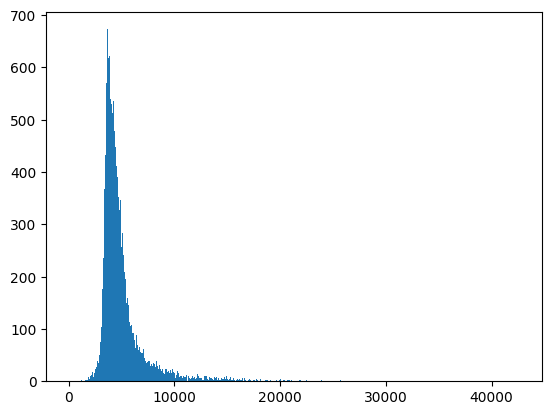

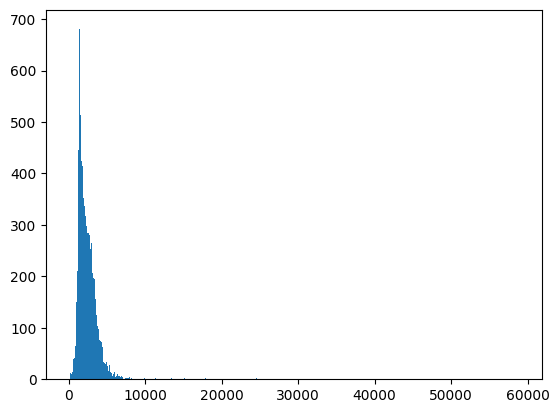

In [69]:
g_df = SG_preprocess_tracks(fpath_list, r"test_009-0", save_images=False)

In [57]:
g_df

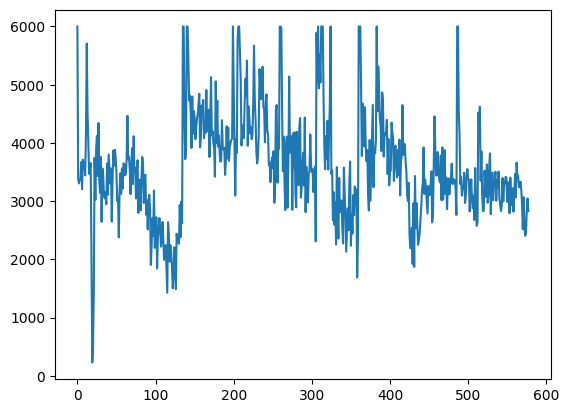

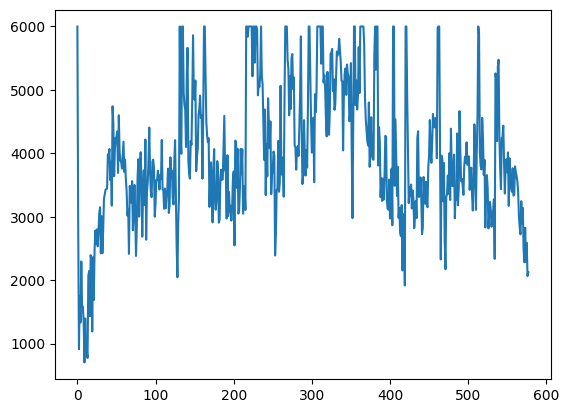

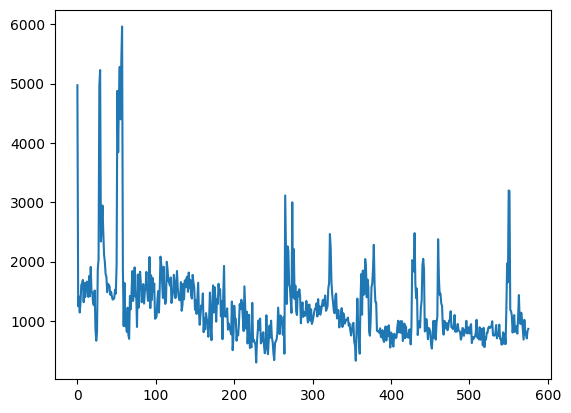

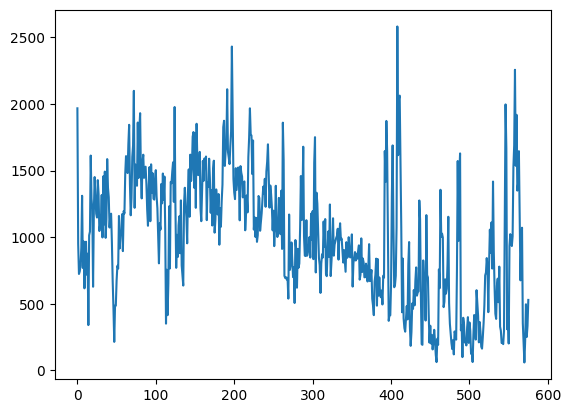

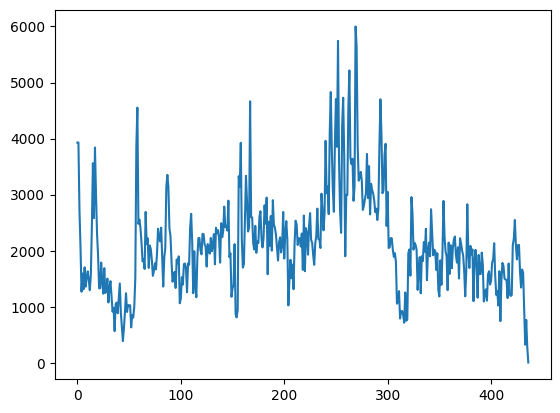

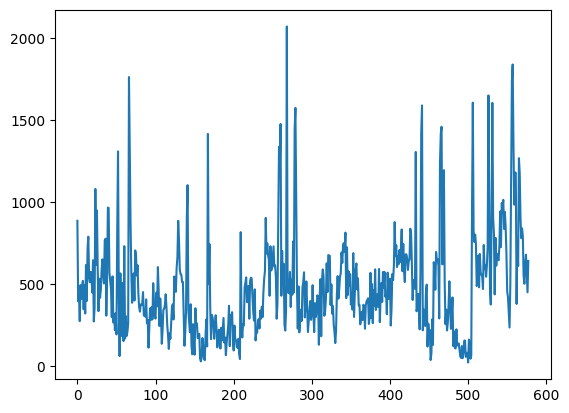

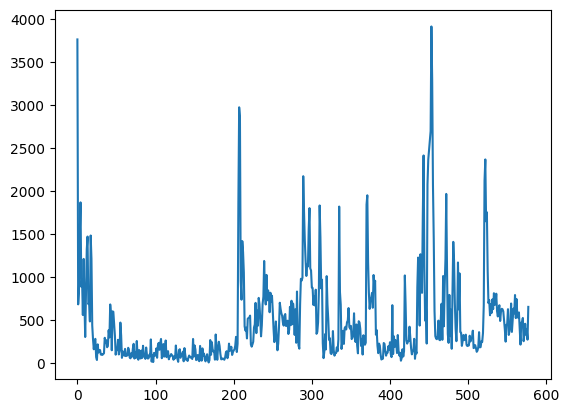

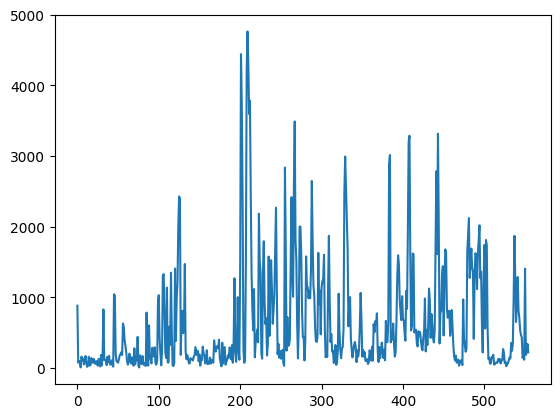

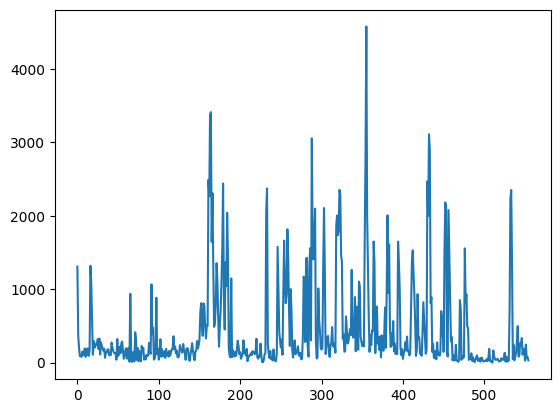

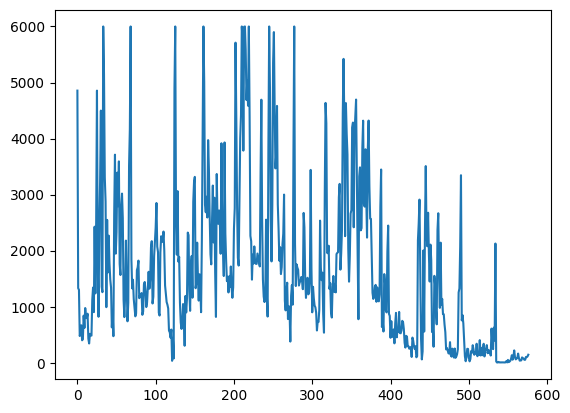

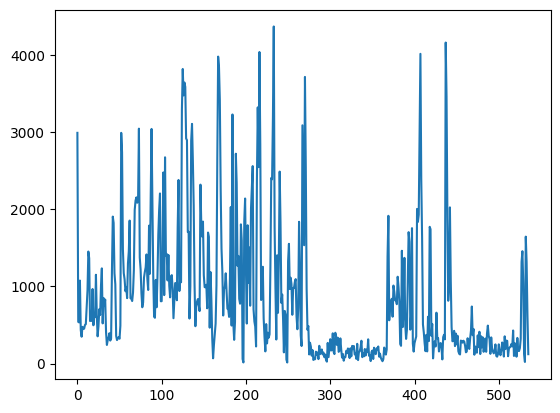

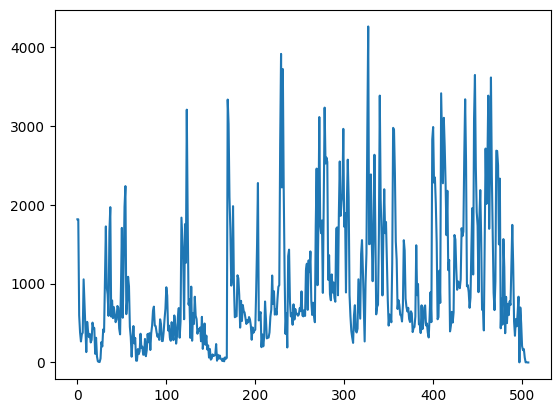

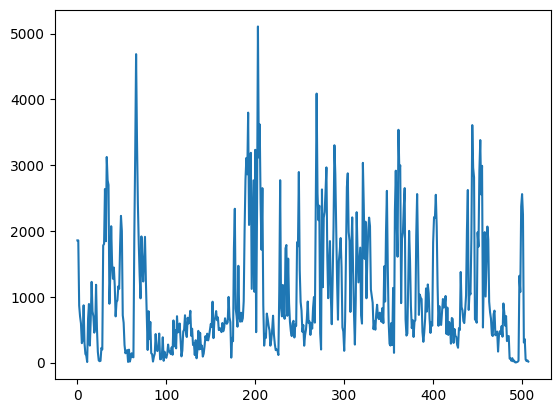

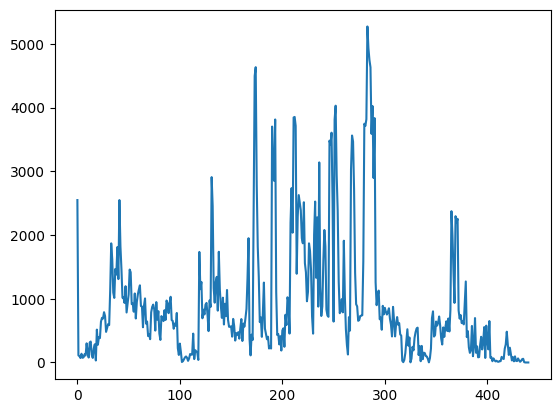

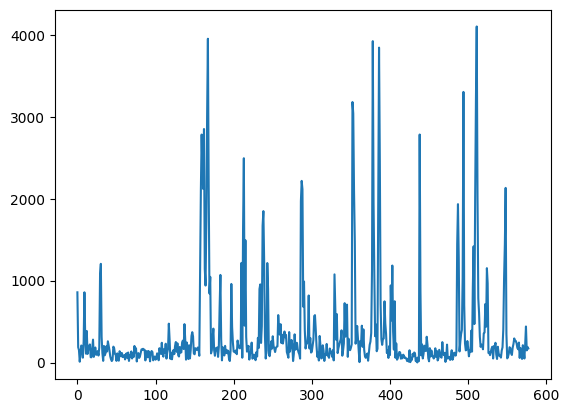

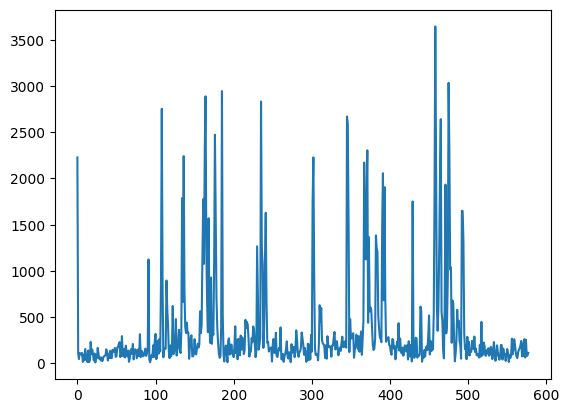

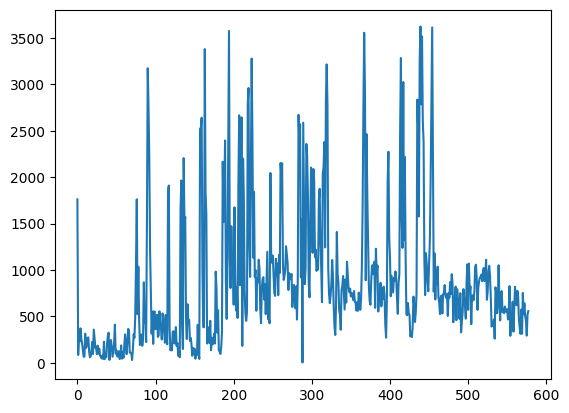

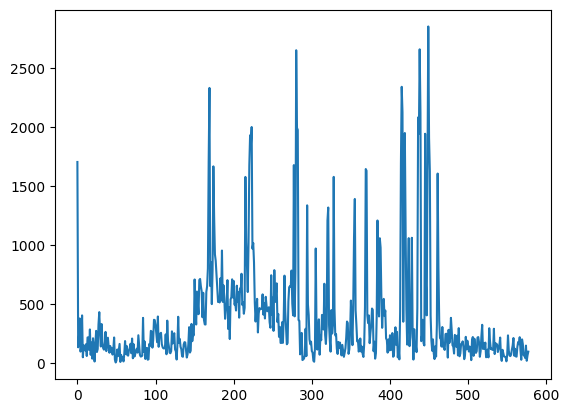

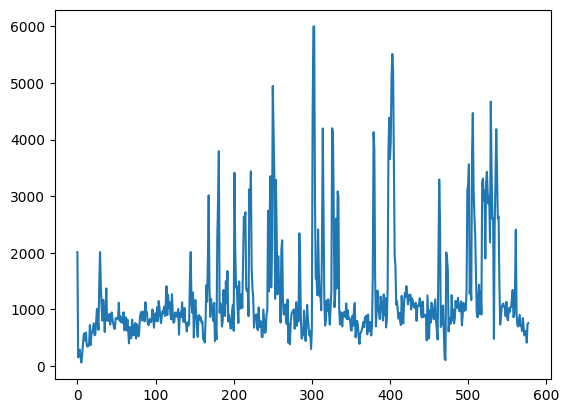

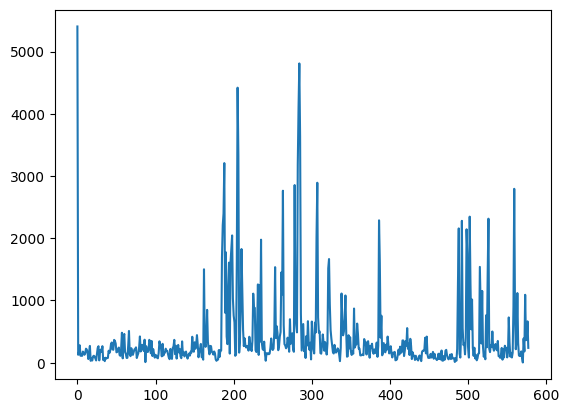

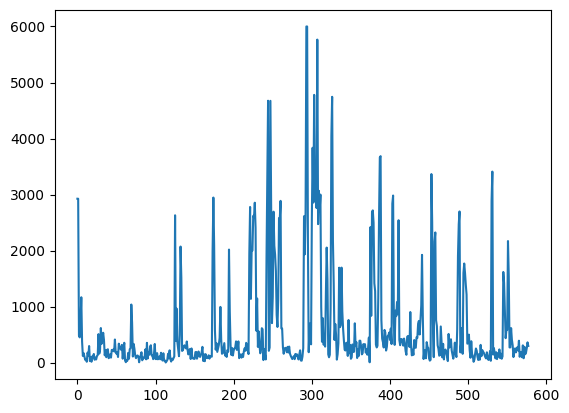

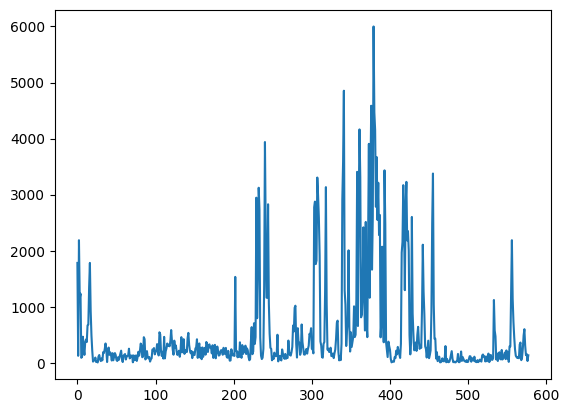

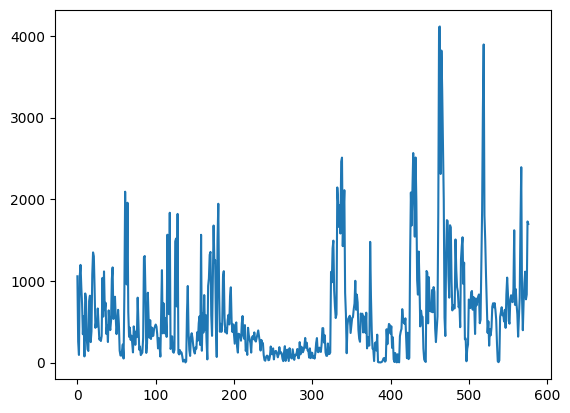

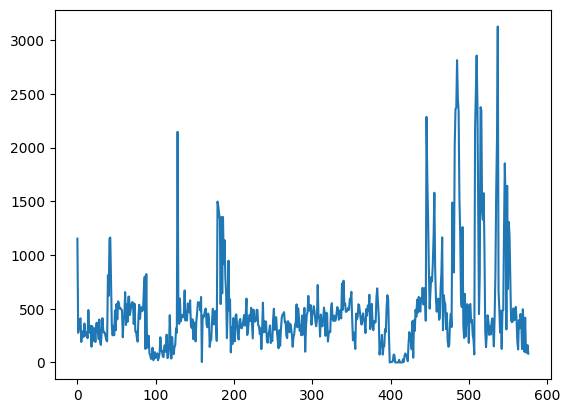

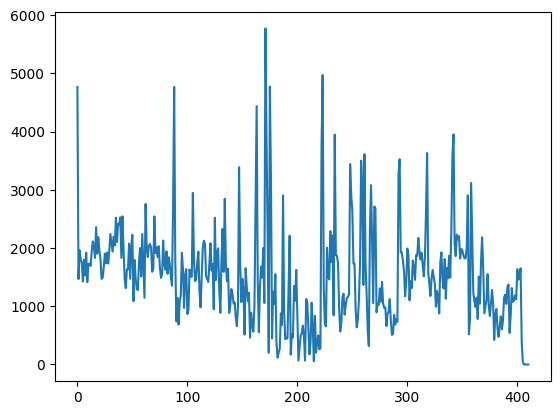

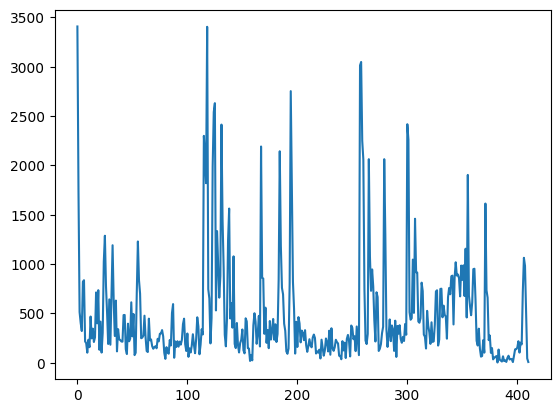

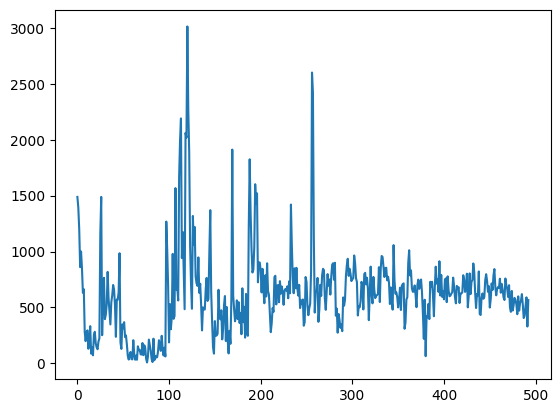

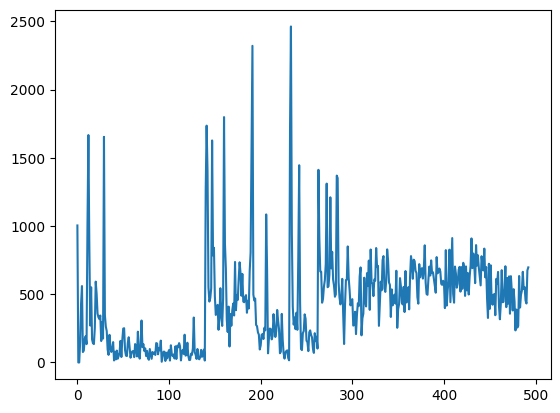

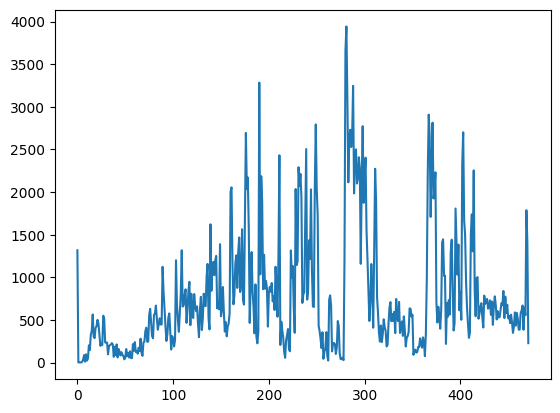

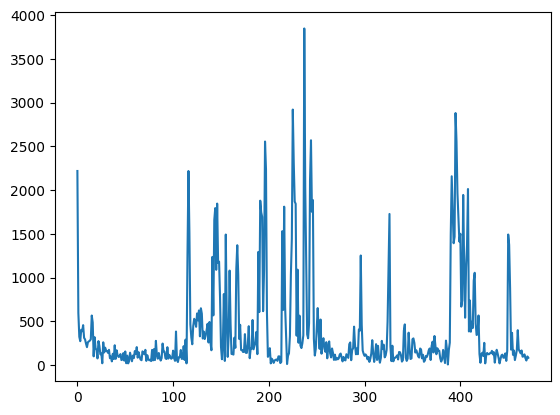

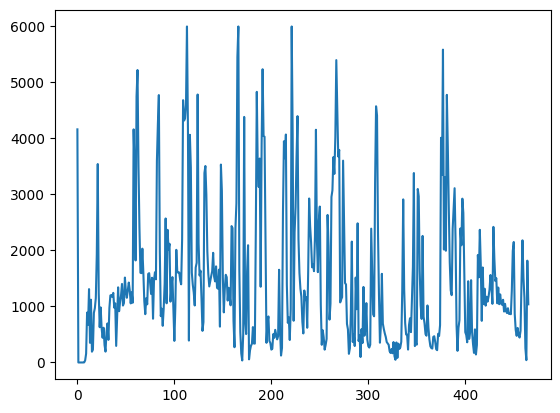

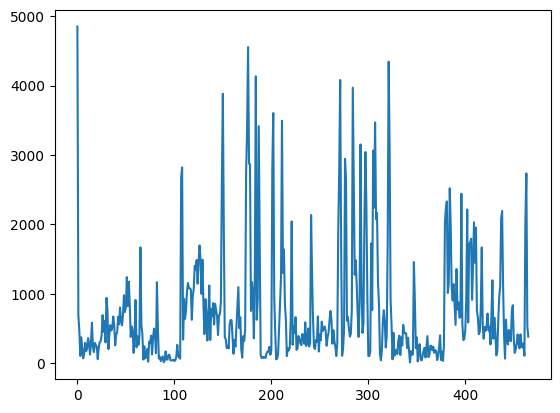

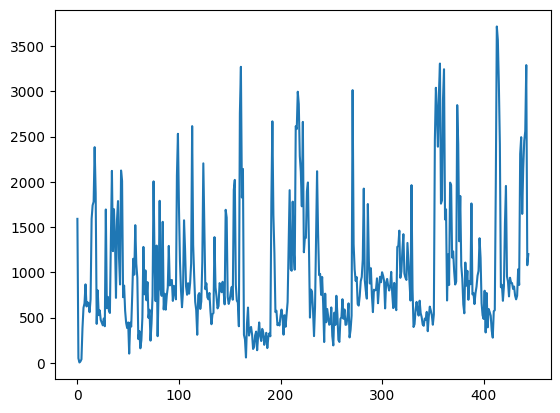

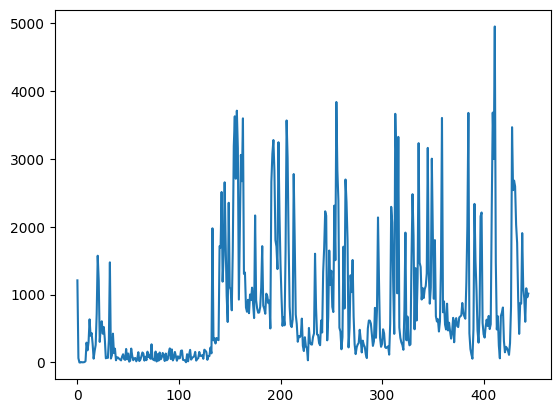

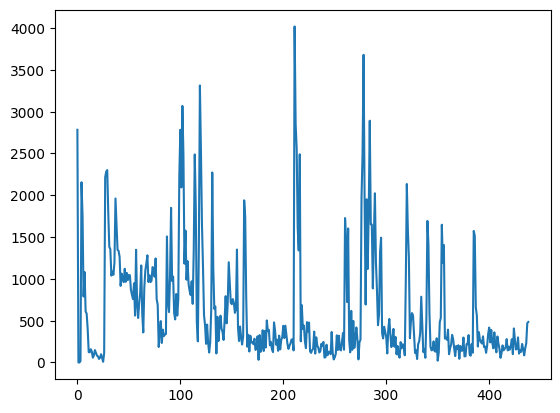

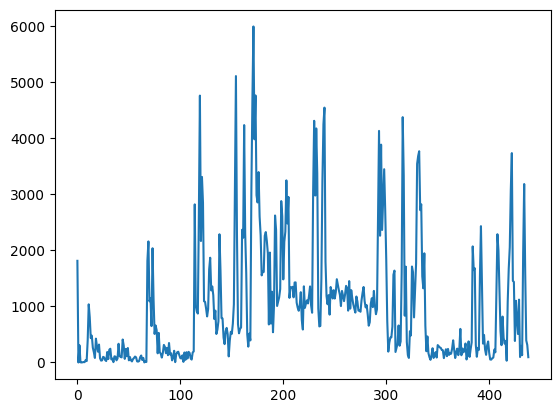

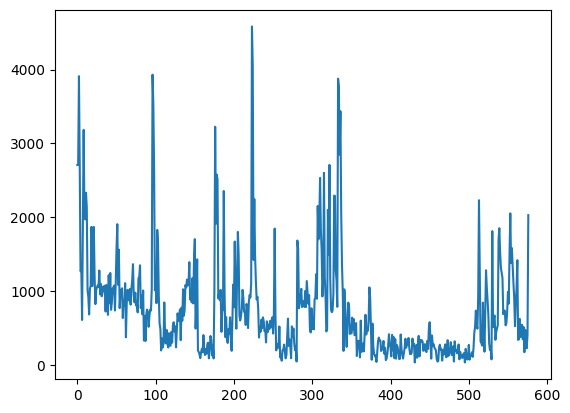

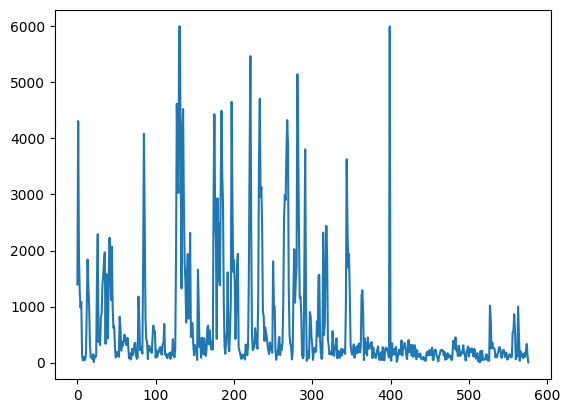

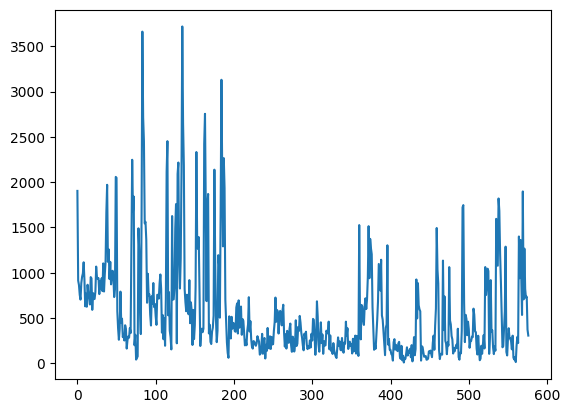

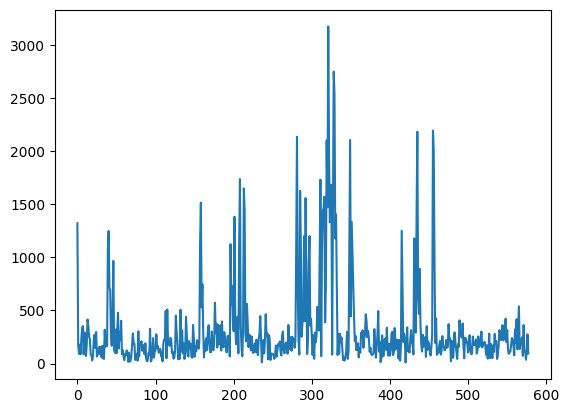

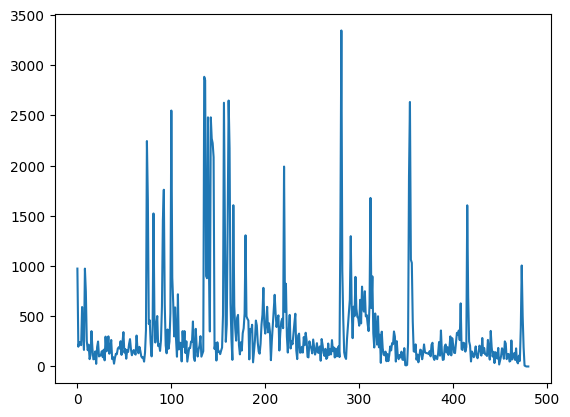

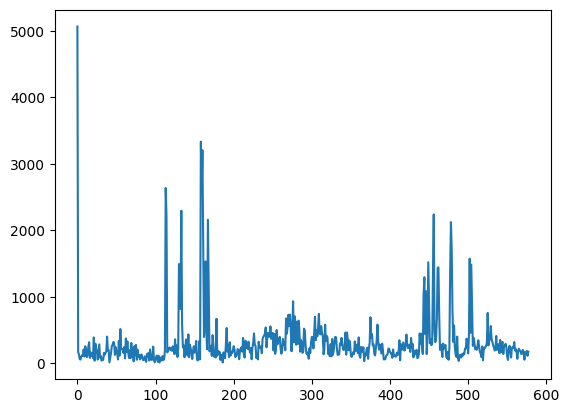

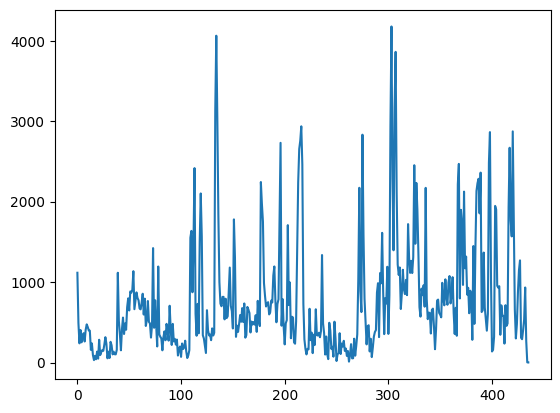

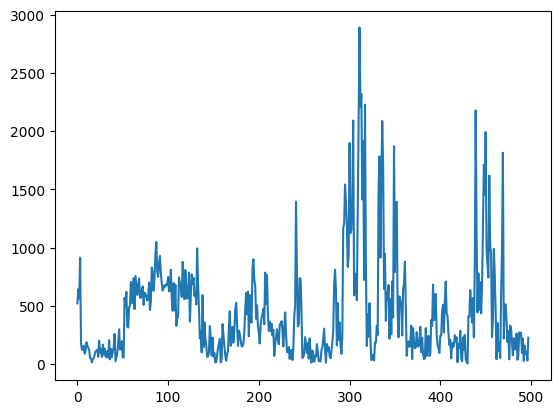

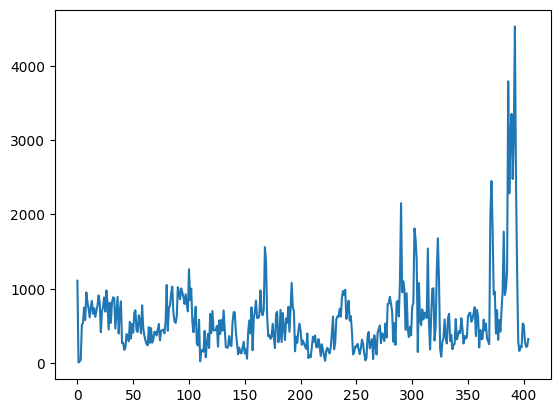

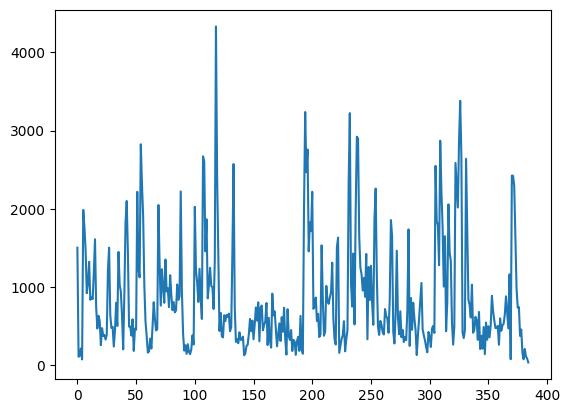

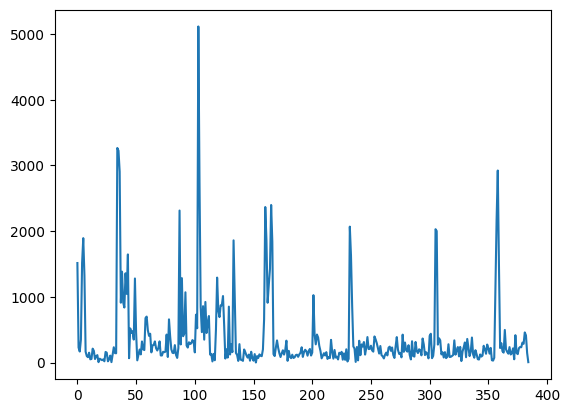

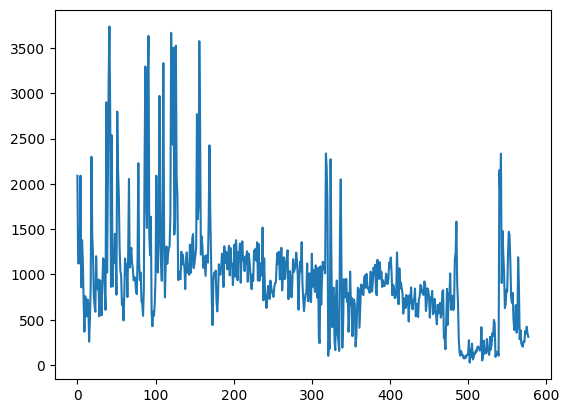

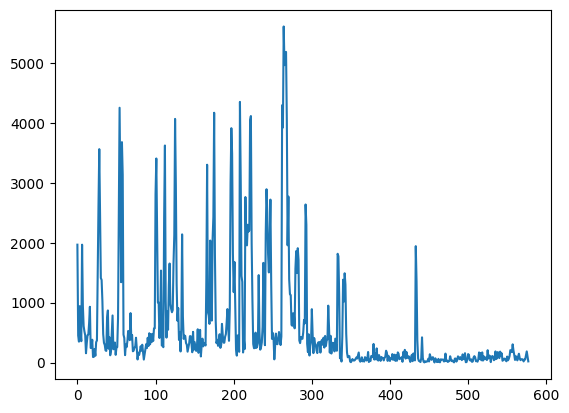

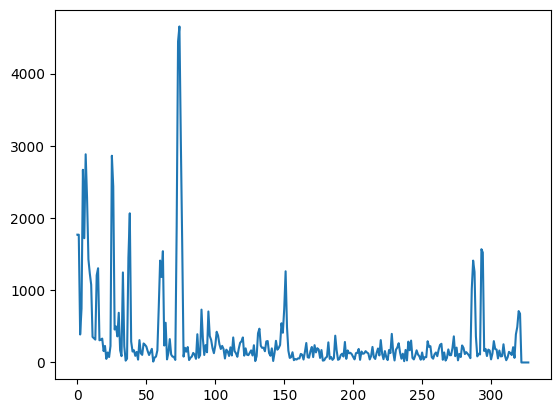

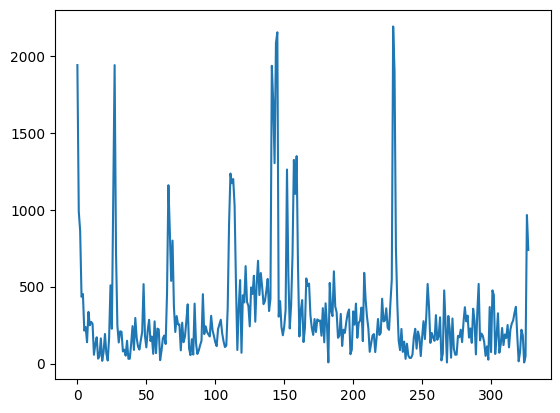

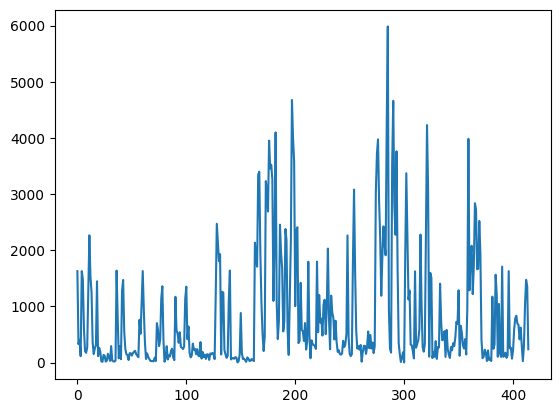

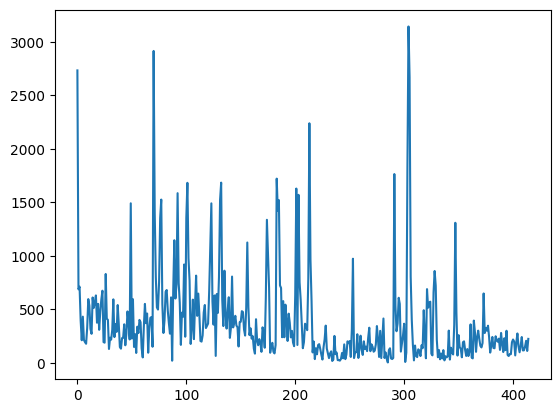

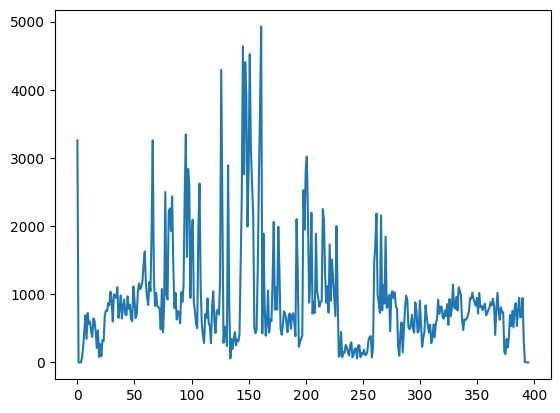

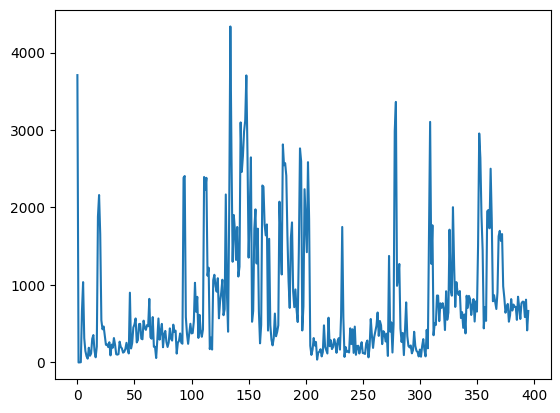

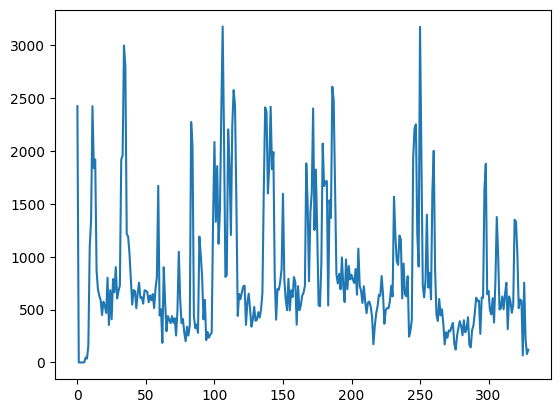

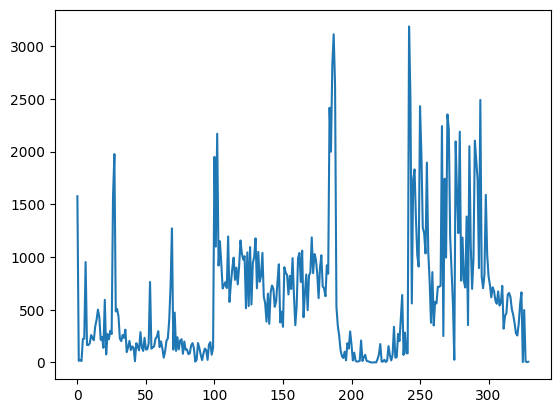

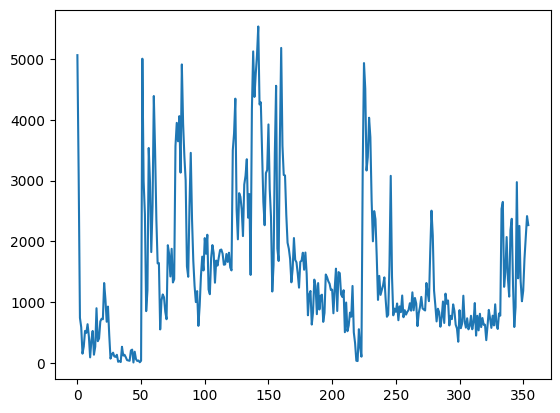

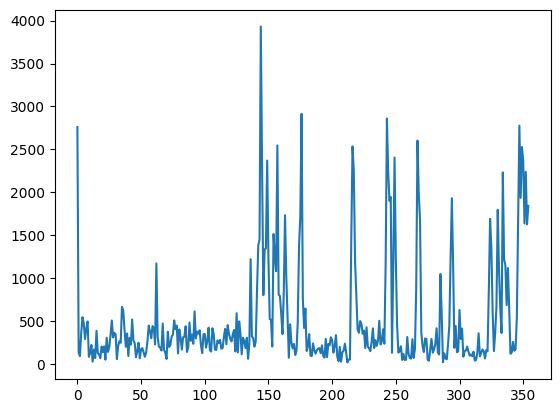

In [49]:
y = g_df.groupby("t")["I"].mean()
for uuid, group in g_df.groupby("UUID"):
    plt.plot(group["t"], group["I"])
    plt.show()
    # plt.plot(np.linspace(-1, 1, len(group["I"])), np.log(np.abs(np.fft.fftshift(np.fft.fft(group["I"])))))
    # plt.show()

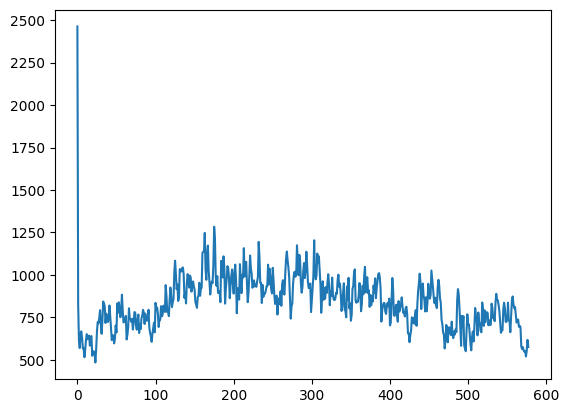

In [34]:
plt.plot(g_df.groupby("t")["I"].mean())
plt.show()